Episode 0, total reward: -22
Episode 1, total reward: 34
Episode 2, total reward: 0
Episode 3, total reward: 56
Episode 4, total reward: -7
Episode 5, total reward: 48
Episode 6, total reward: 51
Episode 7, total reward: 83
Episode 8, total reward: 79
Episode 9, total reward: 77
Episode 10, total reward: 82
Episode 11, total reward: 69
Episode 12, total reward: 41
Episode 13, total reward: 73
Episode 14, total reward: 81
Episode 15, total reward: 86
Episode 16, total reward: 86
Episode 17, total reward: 83
Episode 18, total reward: 86
Episode 19, total reward: 86
Episode 20, total reward: 83
Episode 21, total reward: 90
Episode 22, total reward: 87
Episode 23, total reward: 91
Episode 24, total reward: 76
Episode 25, total reward: 74
Episode 26, total reward: 91
Episode 27, total reward: 89
Episode 28, total reward: 87
Episode 29, total reward: 91
Episode 30, total reward: 90
Episode 31, total reward: 88
Episode 32, total reward: 89
Episode 33, total reward: 88
Episode 34, total reward

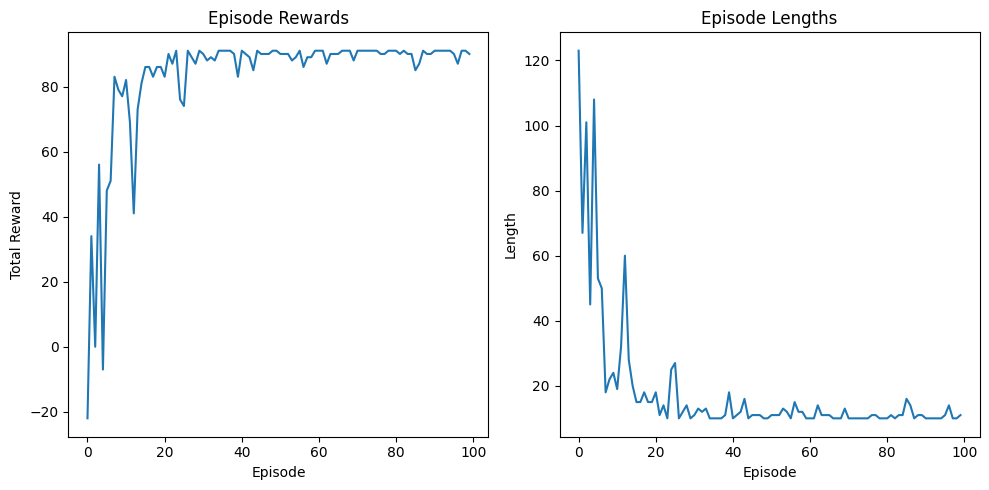

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import matplotlib.pyplot as plt

import random

class EarthquakeEscapeEnv:
    def __init__(self, width=5, height=5, depth=3, num_variations=5):
        self.width = width
        self.height = height
        self.depth = depth
        self.num_variations = num_variations
        self.variations = [self.create_building() for _ in range(num_variations)]

        # Randomly select a building variation
        self.current_building_idx = random.randint(0, num_variations - 1)
        self.building, self.start_location, self.exit_location = self.variations[self.current_building_idx]
        self.agent_position = self.start_location

    def create_building(self):
        building = np.zeros((self.depth, self.height, self.width), dtype=int)

        # Randomly place obstacles
        num_obstacles = random.randint(1, 5)
        for _ in range(num_obstacles):
            z, y, x = random.randint(0, self.depth - 1), random.randint(0, self.height - 1), random.randint(0, self.width - 1)
            building[z, y, x] = -1

        # Randomly set the start location
        start_location = (random.randint(0, self.depth - 1), random.randint(0, self.height - 1), random.randint(0, self.width - 1))

        # Set the exit location (fixed or can be made random)
        exit_location = (0, 0, 0)  # or random.randint(0, self.depth - 1), random.randint(0, self.height - 1), random.randint(0, self.width - 1)

        return building, start_location, exit_location

    def reset(self):
        self.current_building_idx = random.randint(0, self.num_variations - 1)
        self.building, self.start_location, self.exit_location = self.variations[self.current_building_idx]
        self.agent_position = self.start_location
        return self.agent_position

    def step(self, action):
        z, y, x = self.agent_position

        if action == 0:  # move up
            y = max(0, y - 1)
        elif action == 1:  # move down
            y = min(self.height - 1, y + 1)
        elif action == 2:  # move left
            x = max(0, x - 1)
        elif action == 3:  # move right
            x = min(self.width - 1, x + 1)
        elif action == 4:  # move up a floor
            z = max(0, z - 1)
        elif action == 5:  # move down a floor
            z = min(self.depth - 1, z + 1)

        # Check bounds and obstacles
        if 0 <= x < self.width and 0 <= y < self.height and 0 <= z < self.depth:
            if self.building[z, y, x] != -1:
                self.agent_position = (z, y, x)

        reward = -1  # Default step penalty
        done = False

        if self.agent_position == self.exit_location:
            reward = 100  # Reward for reaching the exit
            done = True
        elif self.building[self.agent_position] == -1:
            reward = -10  # Penalty for hitting an obstacle

        return self.agent_position, reward, done




class PolicyNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.softmax(x, dim=-1)

class ValueNetwork(nn.Module):
    def __init__(self, input_size):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class PPOAgent:
    def __init__(self, env, gamma=0.99, lr=3e-4, clip_eps=0.2, update_steps=10):
        self.env = env
        self.gamma = gamma
        self.clip_eps = clip_eps
        self.update_steps = update_steps

        self.policy_net = PolicyNetwork(3, 6).cuda()
        self.value_net = ValueNetwork(3).cuda()

        self.policy_optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.value_optimizer = optim.Adam(self.value_net.parameters(), lr=lr)
    
    def select_action(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).cuda()
        with torch.no_grad():  # 그래디언트 추적 비활성화
            probs = self.policy_net(state_tensor)
            dist = Categorical(probs)
            action = dist.sample()
            log_prob = dist.log_prob(action)
        return action.item(), log_prob

    def update(self, states, actions, log_probs, returns, advantages):
        for _ in range(self.update_steps):
            idxs = np.arange(len(states))
            np.random.shuffle(idxs)
            for i in idxs:
                state = torch.tensor(states[i], dtype=torch.float32).cuda()
                action = torch.tensor(actions[i]).cuda()
                old_log_prob = log_probs[i].cuda()
                R = returns[i]
                advantage = advantages[i]

                prob = self.policy_net(state.unsqueeze(0))
                dist = Categorical(prob)
                new_log_prob = dist.log_prob(action)

                ratio = torch.exp(new_log_prob - old_log_prob)
                surr1 = ratio * advantage
                surr2 = torch.clamp(ratio, 1 - self.clip_eps, 1 + self.clip_eps) * advantage

                policy_loss = -(torch.min(surr1, surr2)).mean()
                value_loss = ((self.value_net(state.unsqueeze(0)) - R).pow(2)).mean()

                self.policy_optimizer.zero_grad()
                policy_loss.backward()
                self.policy_optimizer.step()

                self.value_optimizer.zero_grad()
                value_loss.backward()
                self.value_optimizer.step()



    def compute_returns(self, rewards, dones):
        returns = []
        R = 0
        for r, done in zip(reversed(rewards), reversed(dones)):
            if done:
                R = 0
            R = r + self.gamma * R
            returns.insert(0, R)
        return returns

    
    def train(self, num_episodes):
        episode_rewards = []
        episode_lengths = []
    
        for episode in range(num_episodes):
            state = self.env.reset()
            states, actions, log_probs, rewards, dones = [], [], [], [], []
    
            done = False
            while not done:
                action, log_prob = self.select_action(state)
                next_state, reward, done = self.env.step(action)
    
                states.append(state)
                actions.append(action)
                log_probs.append(log_prob)
                rewards.append(reward)
                dones.append(done)
    
                state = next_state
    
            returns = self.compute_returns(rewards, dones)
            advantages = [r - self.value_net(torch.tensor(s, dtype=torch.float32).unsqueeze(0).cuda()).item() for r, s in zip(returns, states)]
            self.update(states, actions, log_probs, returns, advantages)
    
            episode_rewards.append(sum(rewards))
            episode_lengths.append(len(rewards))
    
            print(f'Episode {episode}, total reward: {sum(rewards)}')
    
        return episode_rewards, episode_lengths

In [ ]:
# 학습 및 성능 평가
env = EarthquakeEscapeEnv()
agent = PPOAgent(env)

# Anomaly detection 활성화
torch.autograd.set_detect_anomaly(True)
episode_rewards, episode_lengths = agent.train(num_episodes=100)

# 성능 비교 시각화
plt.figure(figsize=(10, 5))

# 에피소드별 보상 그래프
plt.subplot(1, 2, 1)
plt.plot(episode_rewards)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

# 에피소드별 길이 그래프
plt.subplot(1, 2, 2)
plt.plot(episode_lengths)
plt.title('Episode Lengths')
plt.xlabel('Episode')
plt.ylabel('Length')

plt.tight_layout()
plt.show()

Training completed. Saving models and plotting training results...


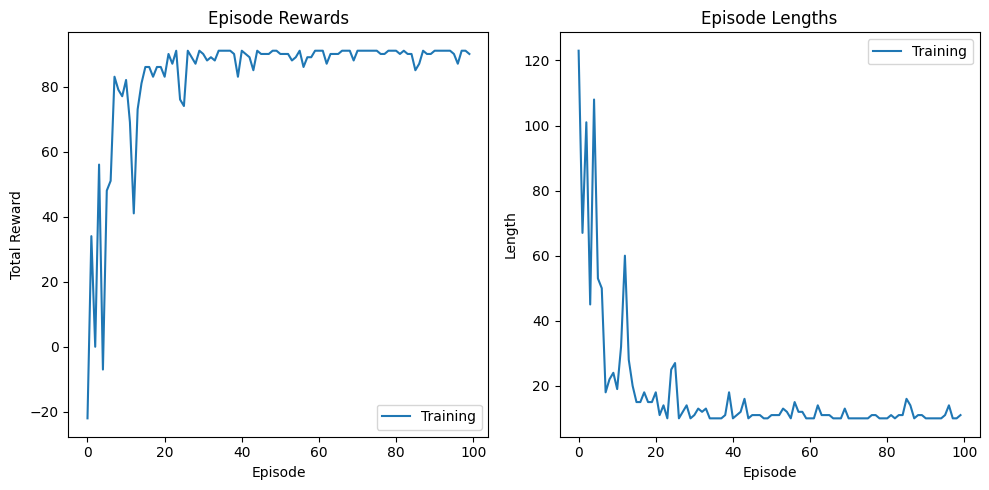

Evaluating the trained model...


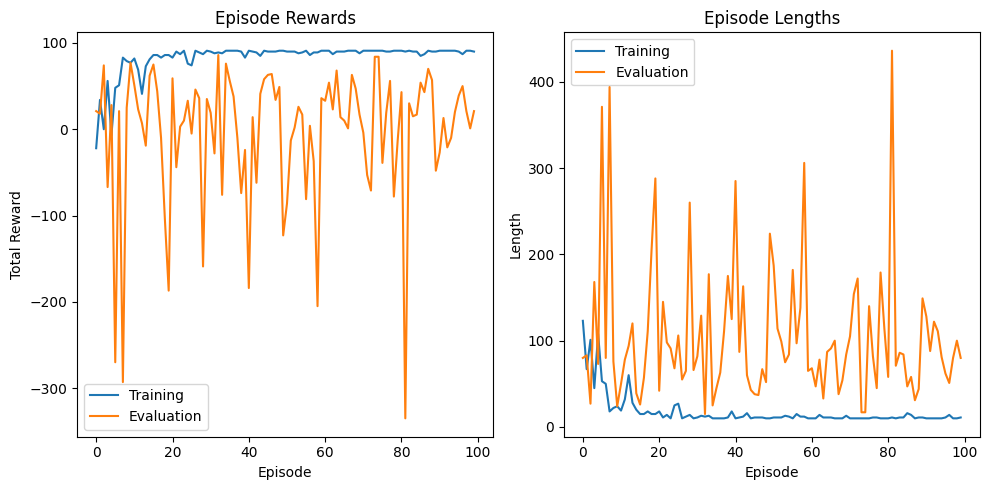

In [17]:
import os

torch.autograd.set_detect_anomaly(True)

# 학습 결과 저장
torch.save(agent.policy_net.state_dict(), 'policy_net.pth')
torch.save(agent.value_net.state_dict(), 'value_net.pth')

# 학습 과정 로깅
print("Training completed. Saving models and plotting training results...")

# 성능 비교 시각화
plt.figure(figsize=(10, 5))

# 에피소드별 보상 그래프
plt.subplot(1, 2, 1)
plt.plot(episode_rewards, label='Training')
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()

# 에피소드별 길이 그래프
plt.subplot(1, 2, 2)
plt.plot(episode_lengths, label='Training')
plt.title('Episode Lengths')
plt.xlabel('Episode')
plt.ylabel('Length')
plt.legend()

plt.tight_layout()
plt.show()

# 이전 체크포인트 로드
policy_net = PolicyNetwork(3, 6).cuda()
value_net = ValueNetwork(3).cuda()

policy_net.load_state_dict(torch.load('policy_net.pth'))
value_net.load_state_dict(torch.load('value_net.pth'))

# 성능 평가를 위한 에이전트 생성
eval_agent = PPOAgent(env)

# 성능 비교를 위한 변수 초기화
eval_episode_rewards = []
eval_episode_lengths = []

# 평가
print("Evaluating the trained model...")
for _ in range(100):  # 100 에피소드 동안 평가
    state = env.reset()
    total_reward = 0
    episode_length = 0
    done = False

    while not done:
        action, _ = eval_agent.select_action(state)
        next_state, reward, done = env.step(action)

        total_reward += reward
        episode_length += 1
        state = next_state

    eval_episode_rewards.append(total_reward)
    eval_episode_lengths.append(episode_length)

# 성능 비교 시각화
plt.figure(figsize=(10, 5))

# 에피소드별 보상 그래프
plt.subplot(1, 2, 1)
plt.plot(episode_rewards, label='Training')
plt.plot(eval_episode_rewards, label='Evaluation')
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()

# 에피소드별 길이 그래프
plt.subplot(1, 2, 2)
plt.plot(episode_lengths, label='Training')
plt.plot(eval_episode_lengths, label='Evaluation')
plt.title('Episode Lengths')
plt.xlabel('Episode')
plt.ylabel('Length')
plt.legend()

plt.tight_layout()
plt.show()
